## Import essential libraries

In [297]:
# Basic libraries
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Text preprocessing libraries
import re
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.utils import resample

# Model training and testing libraries
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

# Model Evaluation libraries
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import classification_report

from tabulate import tabulate
import pickle

## Exploratory Data Analysis

In [298]:
# Load Data
data_df = pd.read_csv('Job titles and industries.csv')

# Print first few rows
data_df.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


In [299]:
# Understanding data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  8586 non-null   object
 1   industry   8586 non-null   object
dtypes: object(2)
memory usage: 134.3+ KB


it seems there're NO null values

In [300]:
data_df.describe().T

,count,unique,top,freq
job title,8586,3890,marketing executive,91
industry,8586,4,IT,4746


In [301]:
# Check if there's any duplicates
data_df.duplicated().value_counts()

True     4618
False    3968
dtype: int64

There're 3968 unique values

### Data Visualization

<AxesSubplot:>

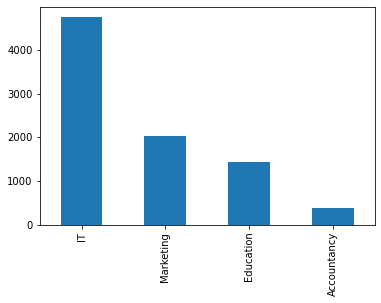

In [302]:
data_df['industry'].value_counts().plot.bar()

In [303]:
# Remove Duplicates
# non_duplicated_data_df = data_df.drop_duplicates()
# non_duplicated_data_df.info()

In [304]:
# non_duplicated_data_df['industry'].value_counts().plot.bar()

## Text Preprocessing

### Noise Removal

In [305]:
def noise_removal(text):
    # remove html markup
    text = re.sub("(<.*?>)","",text)
    
    #remove non-ascii and digits
    text = re.sub("(\\W|\\d)"," ",text)
    
    #remove whitespace
    text = text.strip()
    return text

In [306]:
def text_preprocessing(text):
    # Convert text to lower-case
    text = remove_stopwords(text.lower()).split()
    clean_job_title = ''
    
    # Add some symbols to built-in STOPWORDS
    stop_words = list(STOPWORDS.union(set(['&', ',', '-', '/', '\\', '+', '=', '$', '#', '*'])))
    
    # Remove 'IT' from STOPWORDS
    stop_words.remove('it')
    
    # Add clean word to job title
    for word in text:
        if len(word) >= 2 and word not in stop_words:
            clean_job_title += word + ' '
            
    # Apply noise removal to clean job title
    clean_job_title = noise_removal(clean_job_title)

    return clean_job_title

In [307]:
# Apply text preprocessing to non-duplicated data
# non_duplicated_data_df['job title'] = non_duplicated_data_df['job title'].map(text_preprocessing)
data_df['job title'] = data_df['job title'].map(text_preprocessing)

In [308]:
#pd.set_option('display.max_rows', non_duplicated_data_df.shape[0]+1)
# non_duplicated_data_df
data_df

,job title,industry
0,technical support helpdesk supervisor county b...,IT
1,senior technical support engineer,IT
2,head services,IT
3,js end engineer,IT
4,network telephony controller,IT
...,...,...
8581,data entry clerk,Marketing
8582,content creator,Marketing
8583,sales marketing manager,Marketing
8584,marketing digital marketing consultant,Marketing


## Splitting Data

In [309]:
# X = non_duplicated_data_df['job title']
# y = non_duplicated_data_df['industry']

X = data_df['job title']
y = data_df['industry']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## Solve imbalanced data problem: OverSampling minority class

OverSampling data should be done only on training data after splitting the original data frame to keep the distribution of test data the same.

<AxesSubplot:>

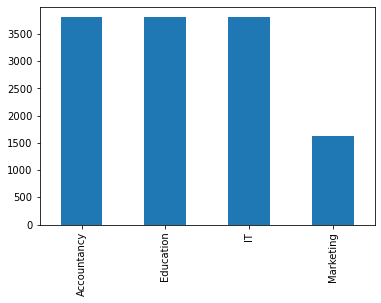

In [310]:
# Merge train data together
X = pd.concat([X_train, y_train], axis=1)

IT = X[X.industry=='IT']
marketing = X[X.industry=='Marketing']
education = X[X.industry=='Education']
accountancy = X[X.industry=='Accountancy']

# OverSampling two minority classes
upsampled_education_data = resample(education, replace=True, n_samples=len(IT), random_state=42)
upsampled_accontancy_data = resample(accountancy, replace=True, n_samples=len(IT), random_state=42)

# Merge OverSampled features together with Majority features
upsampled_data = pd.concat([IT, marketing, upsampled_education_data, upsampled_accontancy_data])

upsampled_data['industry'].value_counts().plot.bar()

Train data seems balanced now.

In [311]:
# Re-split training data into feature and label
X_train, y_train = upsampled_data['job title'], upsampled_data['industry']

In [312]:
# Balance weights to handle imbalanced data
# weights = compute_sample_weight('balanced', y_train)

## Model

In [313]:
# Try many classifiers and choose the one that gives highest accuracy

models = []

models.append(('Logistic Regression', LogisticRegression()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('Linear SVM', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=200, tol=None)))
models.append(('Perceptron', SGDClassifier(loss='perceptron', penalty='l2',alpha=1e-3, random_state=42, max_iter=200, tol=None)))
models.append(('XGboost', XGBClassifier()))
models.append(('Extra Trees Classifier', ExtraTreesClassifier()))
models.append(('Random Forest Classifier', RandomForestClassifier()))
models.append(('Ada Boost Classifier', AdaBoostClassifier(random_state=0, n_estimators=100)))
models.append(('Bagging Classifier',BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)))
models.append(('Gradient Boosting Classifier',GradientBoostingClassifier(random_state=1)))
models.append(('Naive Bayes Classifier', MultinomialNB()))
  
for name, model in models:
    
    ''' Create pipeline to transform text data into a vector on the basis
        of the frequency, learn the vocabulary and inverse document frequency 
        weightings, and pass it to the model to train.
    '''
    clf = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', model),])
    
    # Train the model
    clf.fit(X_train,y_train)
    
    # Test the model
    y_pred = clf.predict(X_test)
    
    # Evaluate the model using 4 different metrics: accuracy, percision, recall, f1_score
    print('{} accuracy: {}\nClassification Report: \n{}'.format(
        name, accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)))

Logistic Regression accuracy: 0.9260768335273574
Classification Report: 
              precision    recall  f1-score   support

 Accountancy       0.76      0.88      0.82        69
   Education       0.88      0.91      0.90       309
          IT       0.97      0.96      0.96       942
   Marketing       0.90      0.87      0.88       398

    accuracy                           0.93      1718
   macro avg       0.88      0.91      0.89      1718
weighted avg       0.93      0.93      0.93      1718

Decision Tree Classifier accuracy: 0.9220023282887078
Classification Report: 
              precision    recall  f1-score   support

 Accountancy       0.85      0.75      0.80        69
   Education       0.88      0.90      0.89       309
          IT       0.96      0.96      0.96       942
   Marketing       0.87      0.87      0.87       398

    accuracy                           0.92      1718
   macro avg       0.89      0.87      0.88      1718
weighted avg       0.92      0.92 

According to previous results the Model that gives the best Performance is Extra Trees Classifier

### Extra Trees Classifier

In [314]:
clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', ExtraTreesClassifier()),])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Extra Trees Classifier accuracy: {}\nClassification Report: \n{}'.format(
        accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)))

Extra Trees Classifier accuracy: 0.9371362048894063
Classification Report: 
              precision    recall  f1-score   support

 Accountancy       0.94      0.86      0.89        69
   Education       0.93      0.89      0.91       309
          IT       0.97      0.97      0.97       942
   Marketing       0.88      0.92      0.90       398

    accuracy                           0.94      1718
   macro avg       0.93      0.91      0.92      1718
weighted avg       0.94      0.94      0.94      1718



### Saving model

In [315]:
# Saving model to disk
pickle.dump(clf, open('model.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))

### Testing

In [316]:
print(model.predict(['Computer Vision Engineer, part time']))
print(model.predict(['Machine Learning Engineer']))


print(model.predict(['English Teacher - Hiring now!']))

print(model.predict(['Manager for our offices in London']))

print(model.predict(['1.Credit Controller']))

['IT']
['IT']
['Education']
['Marketing']
['Accountancy']
